## Описание проекта
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
Имеются данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными.  
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».ерных игр

### 1. Знакомство с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import seaborn as sb
from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


- в таблице 16715 строк  
- по 2 пропуска в столбцах Name и Genre, вероятно, сбой или ошибка оператора.  
- 269 пропусков в столбце Year_of_Release, видимо, дата выпуска неизвестна  
- пропуски в столбцах Critic_Score, User_Score и Rating, оценки не выставлены или неизвестны  
  
  
- значения столбца Year_of_Release  необходимо привести к типу int, так удобнее  
- значения столбца User_Score необходимо привести к типу float64  
  
  
- названия столбцов необходимо перевести в нижний регистр

### 2. Предобработка данных

Переведем все названия столбцов в нижний регистр.

In [4]:
games.columns = games.columns.str.lower()

Удалим строки с пропущенными названиями игр и датами выпуска - у нас нет данных для их восстановления.

In [5]:
games = games.dropna(subset=['name', 'year_of_release'])

Приведем столбцы с годом выпуска к типу integer.

In [6]:
games['year_of_release'] = games['year_of_release'].astype(int)

Солбец user_score переведем из типа object в тип float64. Значения 'tbd' в этом столбце заменим на NaN с помощью параметра errors='coerce'. Tbd в данном случае означает, что юзер еще не определился с оценкой.

In [7]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')

Добавим в датасет новый столбец - суммарная выручка по всем регионам.

In [8]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [9]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             9768 non-null object
total_sales        16444 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


Проверим, есть ли зависимость оценок от объема продаж. Если есть, можно попробовать восстановить значения по этому параметру.

In [10]:
games[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.245349,0.087984
critic_score,0.245349,1.000000,0.579671
user_score,0.087984,0.579671,1.000000


Как видим, оценки пользователей практически не влияют на продажи. Чуть больше соответствия с оценкой критиков, но эта корреляция также не позволяет нам восстановить одни значения на основании других. Это означает, что у нас нет данных для заполнения пропусков в рейтингах, а т.к этих пропусков достаточно много, мы не можем строить прогноз, основываясь на них. К тому же нас интересуют продажи, а здесь данные полные.

### 3. Анализ данных.

Построим график распределения количества проданных игр по годам.

Text(0, 0.5, 'шт.')

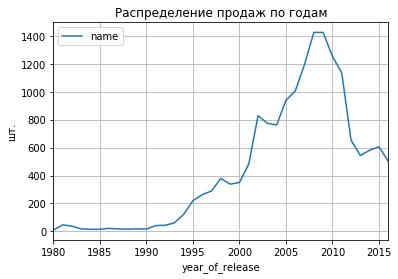

In [11]:
games.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(grid=True, xlim=(1980,2016));
plt.title('Распределение продаж по годам')
plt.ylabel('шт.')

До 1990 года игры практически не продавались, затем начался взрывной рост выпущенных игр с небольшими спадами в 98-м и 2004-м годах. Начиная с 2008 года продажи пошли вниз с небольшим всплеком в 2015-м. Возможно, падение связано с развитием рынка мобильных игр.

Выберем 10 платформ с наибольшими суммарными продажами.

In [12]:
platform_list = (
    games
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .head(10)
)
platform_list

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Для каждой из 10 платформ построим гистограмму количества проданных игр по годам.

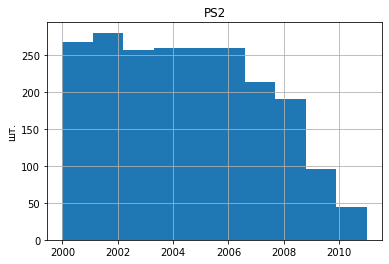

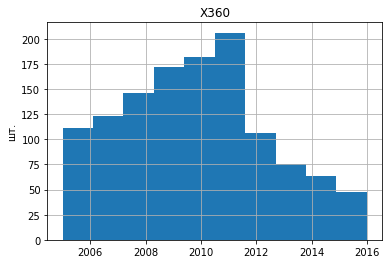

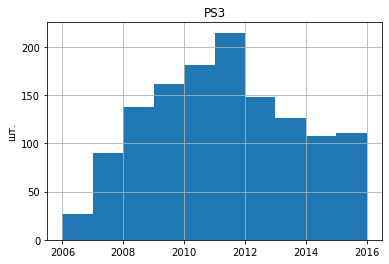

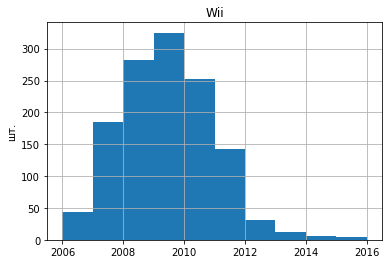

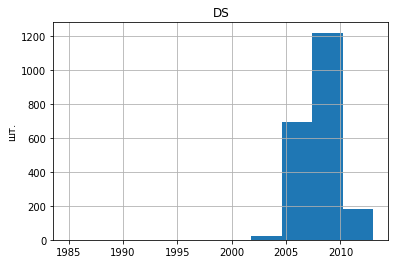

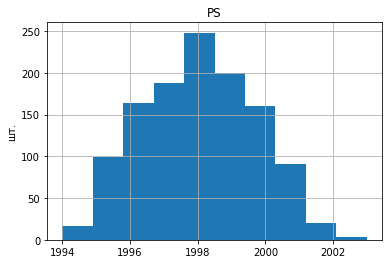

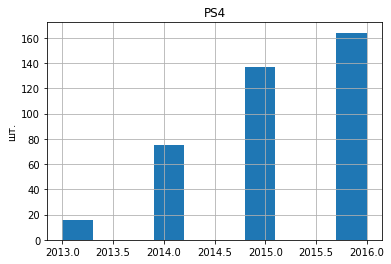

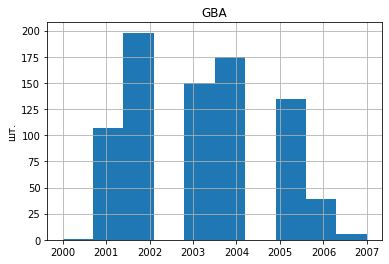

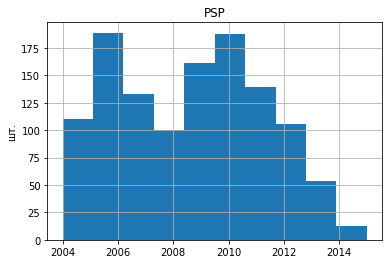

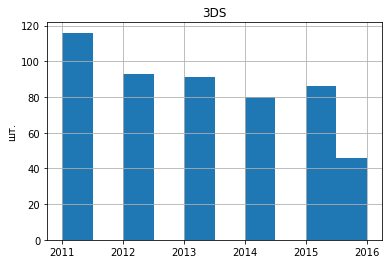

In [13]:
for platform in platform_list.index:
    games.query('platform == @platform').hist('year_of_release')
    plt.title(platform)
    plt.ylabel('шт.')

По полученным графикам определим срок жизни платформы в 8-12 лет. За актуальный период, который можно принять для расчетов возьмем нижнюю границу. Итак, будем обрабатывать данные начиная, с 2009 года. Это, кстати, примерно совпадает с общей тенденцией спада продаж.


In [14]:
games_actual= games.query('year_of_release >= 2009')

Составим рейтинг лидерства по продажам среди платформ.

In [15]:
actual_platform_list = (
    games_actual
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
)
actual_platform_list

,total_sales
platform,
PS3,718.67
X360,670.70
Wii,429.94
PS4,314.14
3DS,257.81
DS,243.29
XOne,159.32
PC,138.87
PSP,101.83


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until


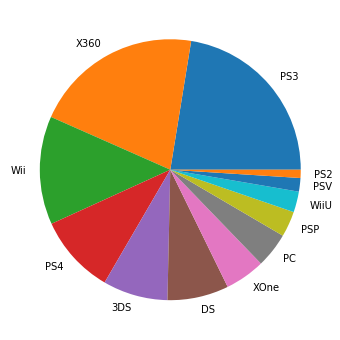

In [16]:
pylab.figure(figsize=(6, 6))
labels = actual_platform_list.index
pylab.pie(actual_platform_list, labels=labels);

В лидерах продаж платформы: X360, PS3-4, Wii и DS(3DS).  
Посмотрим на распределение продаж по годам для каждой платформы.

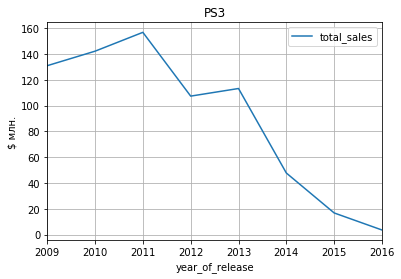

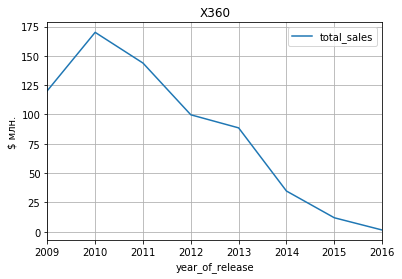

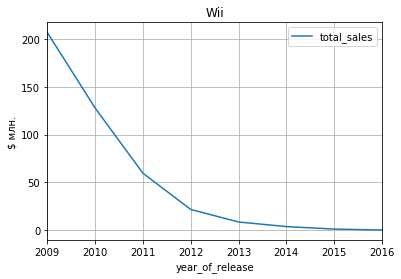

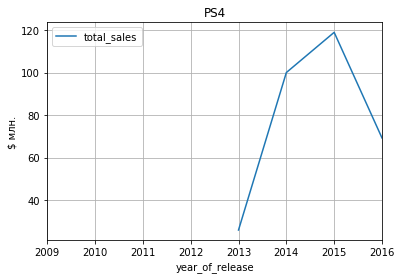

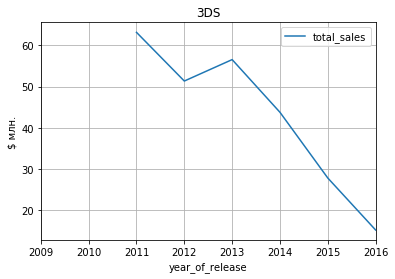

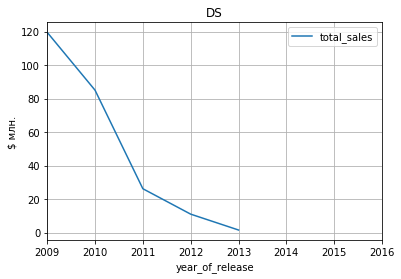

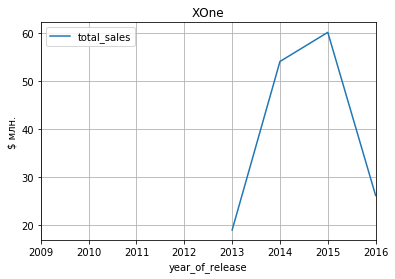

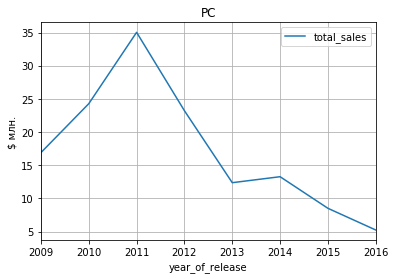

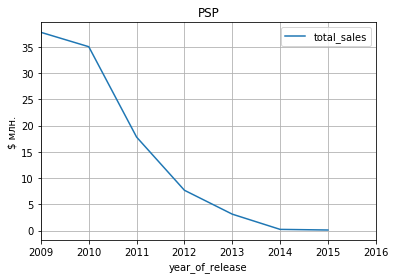

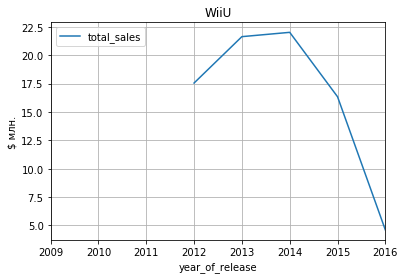

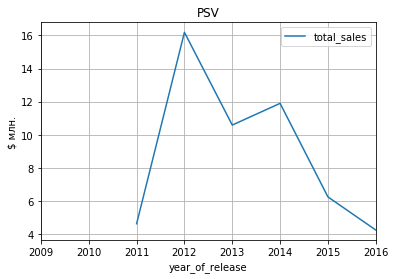

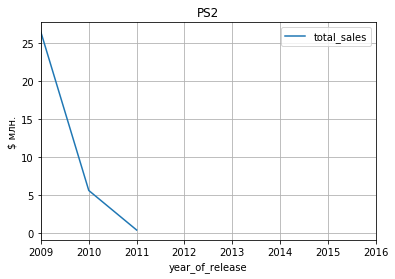

In [17]:
for platform in actual_platform_list.index:    
    (
    games_actual
    .query('platform == @platform')
    .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    .plot(grid=True, xlim=(2009, 2016))
)
    plt.title(platform)
    plt.ylabel('$ млн.')

Как видим, все платформы показывают отрицательную динамику. И, все же, если выбирать, то наиболее прибыльными кажутся платформы PS4, PS3, X360, 3DS, PC, XOne, WiiU, PSV.  
Построим "ящики с усами" для перспективных платформ.

(0, 2)

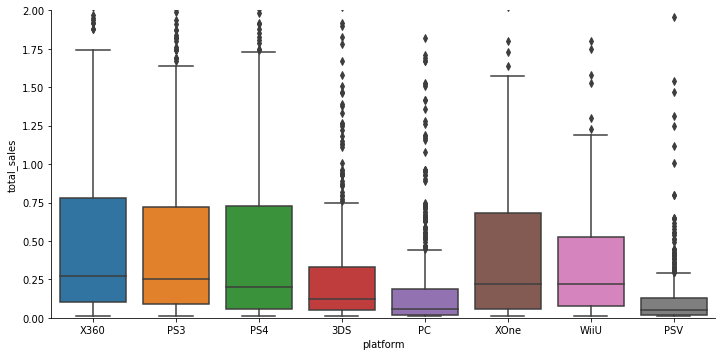

In [18]:
games_perspective = games_actual.query('platform in("PS4", "PS3", "X360", "3DS", "PC", "XOne", "WiiU", "PSV")')
sb.catplot(x='platform', y='total_sales', data=games_perspective, kind='box', height=5, aspect=2)
plt.ylim(0,2)

Видно, что во всех случаях среднее значение намного больше медианы. Это означает, что основную прибыль приносят "хиты" - относительно небольшое количество успешных игр. Общие продажи на платформах существенно различаются, но нужно учитывать, что некоторые из них были запущены значительно позже.

Выберем платформу PS4 и посмотрим, как влияют на продажи отзывы пользователей и критиков.

              total_sales  critic_score  user_score
total_sales      1.000000      0.406568   -0.031957
critic_score     0.406568      1.000000    0.557654
user_score      -0.031957      0.557654    1.000000


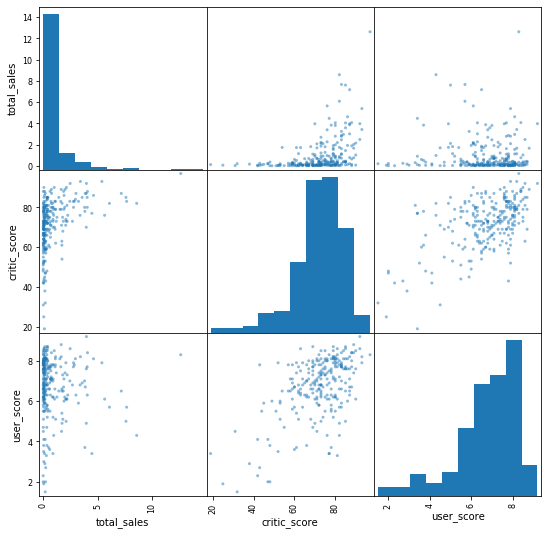

In [19]:
games_actual_PS4 = games_actual.query('platform == "PS4"')[['total_sales', 'critic_score', 'user_score']]
print(games_actual_PS4.corr())
pd.plotting.scatter_matrix(games_actual_PS4, figsize=(9, 9));

Как видим, продажи не зависят от оценок пользователей и коррелируют, хотя и не сильно, с оценками критиков. То есть покупатели всё-таки немного ориентируются при покупке на оценки критиков и уже после составляют своё мнение.  
Посмотрим, что с другими перспективными платформами.

In [20]:
perspective_platform_list = games_perspective['platform'].unique()
for platform in perspective_platform_list:
    print(platform)
    games_actual_platform = games_actual.query('platform == @platform')[['total_sales', 'critic_score', 'user_score']]
    print(games_actual_platform.corr())
    print()
    print()

X360
              total_sales  critic_score  user_score
total_sales      1.000000      0.363933    0.083108
critic_score     0.363933      1.000000    0.622174
user_score       0.083108      0.622174    1.000000


PS3
              total_sales  critic_score  user_score
total_sales      1.000000      0.417976    0.095400
critic_score     0.417976      1.000000    0.634093
user_score       0.095400      0.634093    1.000000


PS4
              total_sales  critic_score  user_score
total_sales      1.000000      0.406568   -0.031957
critic_score     0.406568      1.000000    0.557654
user_score      -0.031957      0.557654    1.000000


3DS
              total_sales  critic_score  user_score
total_sales      1.000000      0.348740    0.222078
critic_score     0.348740      1.000000    0.745222
user_score       0.222078      0.745222    1.000000


PC
              total_sales  critic_score  user_score
total_sales      1.000000      0.297300   -0.012142
critic_score     0.297300      1.000

Видим, что на 4-х платформах наше предположение подтверждается, но на двух (WiiU и 3DS) в части, касающейся оценок пользователей - нет. Значит нельзя полностью исключить влияние оценок покупателей на продажи. Возможно,у этих платформ есть силные сообщества геймеров.

Составим рейтинг жанров по количеству продаж.

In [21]:
games_perspective.pivot_table(index='genre', values ='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)

,total_sales
genre,
Action,664.55
Shooter,531.75
Sports,307.36
Role-Playing,273.92
Misc,146.84
Racing,129.80
Fighting,98.14
Platform,86.27
Simulation,69.73


В лидерах Action, в аутсайдерах паззлы. Вообще на первых ролях игры, которые подразумевают активные действия игрока в реальном времени и, наоборот медленные игры, игры для раздумья отстают.

### 4. Портрет пользователя каждого региона

Рассмотрим самые популярные платформы в различных регионах.

In [22]:
def pivot_top(index, region_sales):
    (
    games_perspective
    .pivot_table(index=index, values=region_sales, aggfunc='sum')
    .sort_values(by=region_sales, ascending=False)
    .head()
    .plot(kind='bar')
    )    
    print()

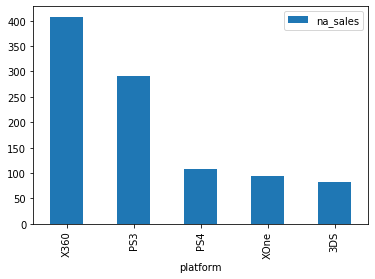

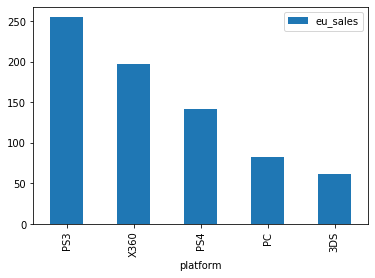

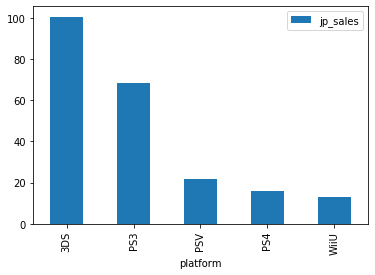

In [23]:
pivot_top('platform', 'na_sales')
pivot_top('platform', 'eu_sales')
pivot_top('platform', 'jp_sales')

Как видим, предпочтения платформ разные в разных регионах. В Америке ожидаемо лидирует X-Box - продукция Micrisoft, Европа предпочитает PlayStation, для Японии в топе только местные производители - Nintendo и Sony. Игры для платформы PC представлены в топ-5 только для европейского рынка, остальные регионы используют приставки.

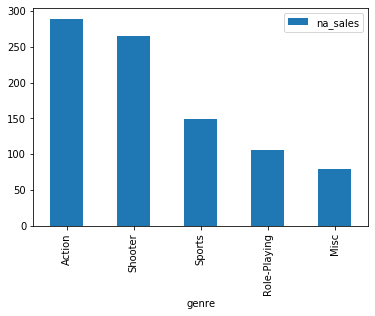

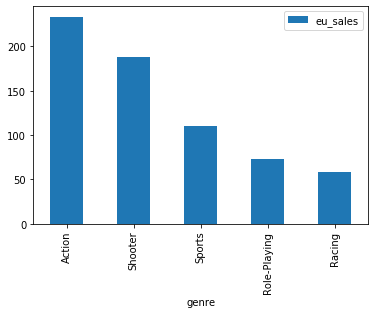

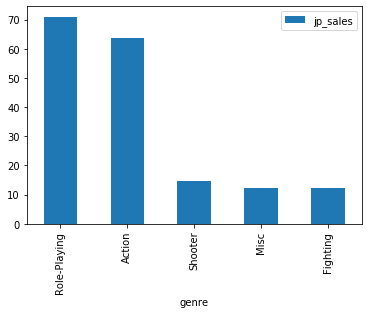

In [24]:
pivot_top('genre', 'na_sales')
pivot_top('genre', 'eu_sales')
pivot_top('genre', 'jp_sales')

В рейтинге жанров Европа и Америка показывают почти одинаковые результаты: экшн - шутеры - спорт - RPG (в Европе еще добавляются гонки). В Японии RPG выходит на первое место, также в топ входит жанр Platform (сложная навигация, прыжки). Нужно, однако, заметить, что классификация - вещь довольно условная, одни и те же игры можно отнести к разным жанрам.  

Итак, американцы предпочитают динамичные игры на платформе X-Box, европейцы - те же жанры, но в большей степени для PlayStation, а также используют для игр персональные компьютеры. Японцы тоже любят динамику, но предпочитают чуть более сложные игры (и в сюжете и в управлении), а для игр используют отечественные игровые платформы.

Проверим, влияет ли рейтинг ESRB на продажи?

In [25]:
print(games_actual.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False))
print()
print(games_actual.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False))
print()
print(games_actual.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False))

        na_sales
rating          
M         440.86
E         403.16
T         227.11
E10+      202.94
EC          1.32
RP          0.00

        eu_sales
rating          
M         326.50
E         261.50
T         153.28
E10+      121.63
RP          0.03
EC          0.00

        jp_sales
rating          
E          61.49
T          50.59
M          35.63
E10+       20.82
EC          0.00
RP          0.00


Как видим, в Европе и Америке на первом месте по продажам игры с рейтингом M (17+) - насилие, секс, ненормативная лексика. В Японии же лидируют игры категории E (Everyone), т.е Япония более "целомудренна".

### 5. Проверка гипотез

Сформулируем гипотезы.  
Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковы.  
Альтернативная гипотеза - рейтинги различаются.  
Зададим пороговое значение в 5%.

In [26]:
rating_xbox = games[games['platform']=='XOne']['user_score'].dropna()
rating_pc = games[games['platform']=='PC']['user_score'].dropna()

print('Средний рейтинг платформы Xbox One: {:.2f}'.format(rating_xbox.mean()))
print('Средний рейтинг платформы PC: {:.2f}'.format(rating_pc.mean()))

alpha = 0.05
results = st.ttest_ind(rating_xbox, rating_pc)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний рейтинг платформы Xbox One: 6.52
Средний рейтинг платформы PC: 7.07
p-значение: 1.3037979620149106e-05
Отвергаем нулевую гипотезу


Пороговое значение на 3 порядка меньше заданного.  
Наш вывод: средний пользовательский рейтинг платформы PC выше рейтинга платформы XBox One.

Проверим еще одну гипотезу.  
Нулевая: средние пользовательские рейтинги жанров Action и Sports одинаковы.  
Альтернативная: ретинги отличаются.  
Пороговое значение также 5%.

In [27]:
rating_action = games[games['genre']=='Action']['user_score'].dropna()
rating_sports = games[games['genre']=='Sports']['user_score'].dropna()

print('Средний рейтинг жанра Action: {:.2f}'.format(rating_action.mean()))
print('Средний рейтинг жанра Sports: {:.2f}'.format(rating_sports.mean()))

alpha = 0.05
results = st.ttest_ind(rating_action, rating_sports)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Средний рейтинг жанра Action: 7.06
Средний рейтинг жанра Sports: 6.95
p-значение: 0.06480928064420527
Не получилось отвергнуть нулевую гипотезу


Разница в средних рейтингах не слишком велика (0.11). С вероятностью в 6.5 процентов она может быть получена случайно, а это больше заданного нами порогового значения в 5%, поэтому мы не можем отвергнуть нулевую гипотезу о равенстве.

### 6. Общий вывод.

Итак, нам требовалось проследить закономерности, которые позволят спланировать рекламные компании для продаж компьютерных игр в 2016 году. В ходе исследования были определены наиболее перспективные платформы для каждого региона продаж, а также наиболее популярные жанры компьютерных игр.  
Определено время жизни платформы. Это 8-12 лет, поэтому на более старшие платформы можно не обращать внимания (исключение составляет разве что PC). Определены наиболее перспективные платформы на 2016год. Это "PS4", "PS3", "X360", "3DS", "PC", "XOne", "WiiU", "PSV". Вместе с тем распределение платформ по регионам различается. В Америке наиболее популярны платформы XBox, в Европе - PlayStation, в Японии - Nintendo.  На персональных копьютерах в основном играют в Европе.  
Также различаются региональные пристрастия в жанрах. Для Европы и Америки на первом месте жанры Action и Shooter, для Японии - RPG, хотя Action тоже имеет большую долю продаж.  
Стоит уделить внимание работе с критиками, т.к. их отзывы оказывают на продажи заметное влияние.  Также, возможно, стоит уделить внимание сообществам геймеров платформ WiiU и 3DS (очевидно, что бОльшая их часть живет в Японии).
